In [1]:
from sklearn.ensemble import RandomForestRegressor
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
def prepros(train_file, test_file, ground_file):
    # read training data - It is the aircraft engine run-to-failure data.
    train_df = pd.read_csv(train_file, sep=" ", header=None)

    #remove the columns 26 and 27 because of NAN values
    train_df=train_df.loc[:,0:25]

    train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                         's15', 's16', 's17', 's18', 's19', 's20', 's21']

    train_df = train_df.sort_values(['id','cycle'])

    # read test data - It is the aircraft engine operating data without failure events recorded.
    test_df = pd.read_csv(test_file, sep=" ", header=None)

    #remove the columns 26 and 27 because of NAN values
    test_df=test_df.loc[:,0:25]

    test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                         's15', 's16', 's17', 's18', 's19', 's20', 's21']

    test_df = test_df.sort_values(['id','cycle'])

    #read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
    truth_df = pd.read_csv(ground_file, sep=" ", header=None)

    #remove the columns 1 because of NAN values
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    truth_df.columns = ['cycle']

    # Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
    ##TRAINING DATASET
    rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']

    train_df = train_df.merge(rul, on=['id'], how='left')

    train_df['RUL'] = train_df['max'] - train_df['cycle']
    train_df.drop('max', axis=1, inplace=True)

    # generate label columns for training data
    # we will only make use of "label1" for binary classification, 
    # while trying to answer the question: is a specific engine going to fail within w1 cycles?
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

    #check columns with repeated values: setting3, s1, s5, s10, s16,s18,s19
    train_df.apply(lambda x: x.nunique())
    train_df.drop(train_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)

    #TEST DATASET
    test_df.drop(test_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)
    test_df.apply(lambda x: x.nunique())

    # We use the ground truth dataset to generate labels for the test data.
    # generate column max for test data
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()

    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)

    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop('max', axis=1, inplace=True)

    # generate label columns w0 and w1 for test data
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

    # MinMax normalization (from 0 to 1)
    min_max_scaler = preprocessing.MinMaxScaler()

    ###TRAIN#####
    train_df['cycle_norm'] = train_df['cycle']
    cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)

    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)

    ####TEST#####
    test_df['cycle_norm'] = test_df['cycle']
    test_df['id_norm'] = test_df['id']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)

    #### Generating input data
    # pick the feature columns 
    sequence_cols = train_df.columns.difference(['id','cycle','RUL','label1','label2'])

    # generate sequences and convert to numpy array
    X_train = train_df[sequence_cols]

    #obtain the last cycle data for each test battery
    test_df=test_df.loc[test_df.groupby('id').cycle.idxmax()]
    X_test = test_df[sequence_cols]
    # Generate labels
    y_train=train_df['RUL']
    y_test=test_df['RUL']
    return (X_train, y_train, X_test, y_test)

In [2]:
X_train_1, y_train_1, X_test_1, y_test_1 = prepros('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt')
X_train_2, y_train_2, X_test_2, y_test_2 = prepros('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt')
X_train_3, y_train_3, X_test_3, y_test_3 = prepros('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt')
X_train_4, y_train_4, X_test_4, y_test_4 = prepros('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [3]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [4]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_1 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_1.fit(X_train_1, y_train_1)
rf_random_1.best_params_
# {'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 10,
#  'n_estimators': 800}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 53.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 107.9min finished


{'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 800}

In [5]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_2.fit(X_train_2, y_train_2)
rf_random_2.best_params_
# {'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 2,
#  'n_estimators': 700}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 207.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 371.2min finished


{'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 700}

In [6]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_3 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_3.fit(X_train_3, y_train_3)
rf_random_3.best_params_
# {'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 10,
#  'n_estimators': 500}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 119.8min finished


{'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 500}

In [7]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random_4 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_4.fit(X_train_4, y_train_4)
rf_random_4.best_params_
# {'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 2,
#  'n_estimators': 800}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 210.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 395.4min finished


{'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 800}

In [9]:
import time

def training_func(X_train_data, y_train_data,max_features_,min_samples_leaf_,
                  min_samples_split_,n_estimators_):
    regr = RandomForestRegressor(max_features=max_features_,
                                 min_samples_leaf=min_samples_leaf_,
                                 min_samples_split=min_samples_split_,
                                 n_estimators=n_estimators_,
                                 verbose=1)
    start = time.time()
    regr.fit(X_train_data, y_train_data)
    end = time.time()
    training_time = end - start
    return (regr, training_time)

In [10]:
clf_1, training_time_1 = training_func(X_train_1, y_train_1, 'sqrt', 4, 10, 800)
clf_2, training_time_2 = training_func(X_train_2, y_train_2, 'sqrt', 4, 2, 700)
clf_3, training_time_3 = training_func(X_train_3, y_train_3, 'sqrt', 4, 10, 500)
clf_4, training_time_4 = training_func(X_train_4, y_train_4, 'sqrt', 4, 2, 800)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   36.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   28.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:  2.5min finished


In [11]:
y_pred_1 = clf_1.predict(X_test_1)
y_pred_2 = clf_2.predict(X_test_2)
y_pred_3 = clf_3.predict(X_test_3)
y_pred_4 = clf_4.predict(X_test_4)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 700 out of 700 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    1.6s finished


In [12]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
def plot_pred(y_pred, y_test):
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred, color="blue")
    plt.plot(y_test.values, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_RF_verify.png")

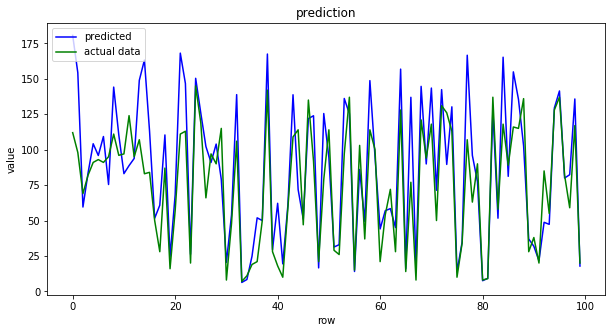

In [13]:
plot_pred(y_pred_1, y_test_1)

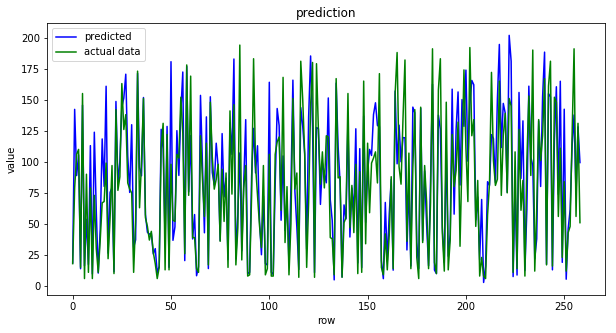

In [14]:
plot_pred(y_pred_2, y_test_2)

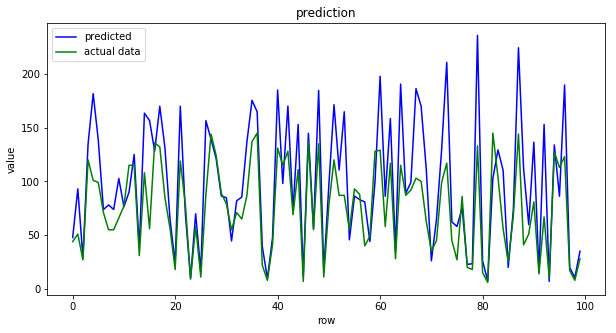

In [15]:
plot_pred(y_pred_3, y_test_3)

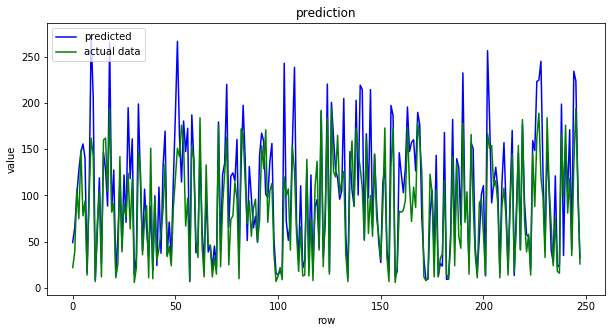

In [16]:
plot_pred(y_pred_4, y_test_4)

In [17]:
def scoring_function(true, pred):
    d = pred - true
    length = len(d)
    s = 0
    for i in range(length):
        if (d[i] < 0):
            s += np.exp((-d[i]/10))-1
        else:
            s += np.exp((d[i]/13))-1
    return s


def rmse(true, pred):
    d_squared = (pred - true)**2
    err = np.mean(d_squared)
    err = np.sqrt(err)
    return err


def mae(true,pred):
    d=abs(pred - true)
    err=np.mean(d)
    return err

y_test = [y_test_1.values,y_test_2.values,y_test_3.values,y_test_4.values]
y_pred = [y_pred_1,y_pred_2,y_pred_3,y_pred_4]

sf_all = [scoring_function(test,pred) for test, pred in zip(y_test, y_pred)]
rmse_all = [rmse(test,pred) for test, pred in zip(y_test, y_pred)]
mae_all = [mae(test,pred) for test, pred in zip(y_test, y_pred)]
cor_all =[np.corrcoef(test, pred) for test, pred in zip(y_test, y_pred)]
all_training_time = [training_time_1,training_time_2,training_time_3,training_time_4]

In [18]:
d = {'Scoring Function': sf_all, 'RMSE': rmse_all, 'MAE':mae_all, 'Correlation':cor_all, 'Training Time': all_training_time}
def final_results(d):
    df = pd.DataFrame(data=d)
    df.index += 1
    df.index.name='CMAPSS Dataset'
    return df

final_results(d)

,Correlation,MAE,RMSE,Scoring Function,Training Time
CMAPSS Dataset,,,,,
1,"[[1.0, 0.8754539108777488], [0.875453910877748...",18.962036,25.743528,1672.520841,37.020665
2,"[[1.0, 0.8680124064662013], [0.868012406466201...",20.087852,27.806311,30751.272772,110.547938
3,"[[1.0, 0.8598349377925835], [0.859834937792583...",27.194173,38.309910,11356.709776,28.768761
4,"[[1.0, 0.8512181145054853], [0.851218114505485...",27.739240,38.355774,71407.690293,148.249946


In [3]:
X_train_1

,cycle_norm,s11,s12,s13,s14,s15,s17,s2,s20,s21,s3,s4,s6,s7,s8,s9,setting1,setting2
0,0.000000,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.183735,0.713178,0.724662,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.459770,0.166667
1,0.002770,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.283133,0.666667,0.731014,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.609195,0.250000
2,0.005540,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.343373,0.627907,0.621375,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.252874,0.750000
3,0.008310,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.343373,0.573643,0.662386,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.540230,0.500000
4,0.011080,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.349398,0.589147,0.704502,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.390805,0.333333
5,0.013850,0.184524,0.637527,0.220588,0.169832,0.330512,0.250000,0.268072,0.651163,0.652720,0.292784,0.272113,1.0,0.776167,0.181818,0.125415,0.252874,0.416667
6,0.016620,0.303571,0.773987,0.220588,0.167097,0.278953,0.333333,0.382530,0.744186,0.667219,0.463920,0.261985,1.0,0.723027,0.181818,0.167818,0.557471,0.583333
7,0.019391,0.232143,0.805970,0.220588,0.160646,0.318199,0.250000,0.406627,0.643411,0.574979,0.259865,0.316003,1.0,0.644122,0.151515,0.085569,0.304598,0.750000
8,0.022161,0.261905,0.660981,0.250000,0.132883,0.184302,0.333333,0.274096,0.705426,0.707539,0.434707,0.211850,1.0,0.618357,0.227273,0.110967,0.545977,0.583333
9,0.024931,0.107143,0.660981,0.264706,0.151925,0.399000,0.416667,0.150602,0.627907,0.794256,0.440375,0.307394,1.0,0.602254,0.227273,0.134479,0.310345,0.583333
